<h1 align="center"><b>Interconnect clients churn forecast project</b></h1>
The main objective of the project is to predict which clients are inclined to leave, allowing Interconnect to implement targeted retention strategies and strengthen customer loyalty.

<h2 align="center">Project roadmap</h2>

1. Load & merge contract.csv, personal.csv, internet.csv, phone.csv by customerID.

2. Reference date: contracts are valid as of 2020-02-01. Parse dates; compute tenure_months robustly.

3. Target(s): build y_churn and y_active as above; pick one for modeling (default: y_churn).

4. Leakage control:

- Keep EndDate only to create target, then drop it from features.

- Drop columns that are identifiers or purely post-factum.

5. Preprocess:

- Numeric: impute median, keep as float.

- Categorical: low-cardinality one-hot; treat “No internet/phone service” as a valid category.

6. Split: stratified Train/Valid/Test (e.g., 60/20/20).

7. Baseline: Logistic Regression (balanced class_weight).

8. Strong models: Gradient Boosting (CatBoost or LightGBM) + RandomForest.

9. Hyperparam search: randomized or Optuna on the validation fold; metric = ROC-AUC.

10. Threshold tuning (on validation) to maximize Accuracy (secondary) while keeping ROC-AUC primary.

11. Final: retrain on Train+Valid with best params; evaluate on Test.

12. Deliverables: ROC-AUC (primary), Accuracy (secondary), confusion matrix at chosen threshold, and top features.

## *Clarifying questions*

*Does contract type affect churn?*
Yes. Month-to-month customers churn the most; one-year churns less; two-year the least. (It’s the top driver in the model.)

*Does tenure matter?*
Yes. New customers (0–6 months) churn the most; the longer the tenure, the lower the churn.

*Do security/support add-ons help? (OnlineSecurity, TechSupport)*
Yes. Customers with No OnlineSecurity or No TechSupport churn more than those with these add-ons.

*Does internet service type affect churn?*
Yes. Fiber optic users churn more than DSL; customers with no internet service churn less (often phone-only/basic plans).

*Do payment methods matter?*
Yes. Electronic check users have higher churn than other payment methods.

*Does paperless billing matter?*
Slightly. Paperless billing shows a small association with higher churn vs. non-paperless.

*Do personal features matter (gender, SeniorCitizen, Partner, Dependents)?*
Mostly small effects. Gender ~ no effect. SeniorCitizen is a small positive risk. Having a Partner/Dependents is slightly protective.

*Do price levels matter (MonthlyCharges)?*
Yes. Higher MonthlyCharges align with higher churn risk.

*Do multiple phone lines matter?*
Small effect. Having multiple lines isn’t a primary driver compared to contract/tenure/security.

*Overall model quality (final)*
Test ROC-AUC = 0.846 (4.5 SP). At the 0.5 threshold, Accuracy ≈ 0.805 with a balanced confusion matrix; using a validation-tuned threshold gave similar accuracy.

In [103]:
# Importing all the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [104]:
# loading datasets 
contract = pd.read_csv('/workspaces/Churn-Prediction/contract.csv')
personal = pd.read_csv('/workspaces/Churn-Prediction/personal.csv')
internet = pd.read_csv('/workspaces/Churn-Prediction/internet.csv')
phone = pd.read_csv('/workspaces/Churn-Prediction/phone.csv')

In [105]:
# loading first 5 rows of dataset
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [106]:
# Checking general information 
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [107]:
# loading first 5 rows of dataset
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [108]:
# Checking general information
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [109]:
# loading first 5 rows of dataset
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [110]:
# Checking general information
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [111]:
# loading first 5 rows of dataset
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [112]:
# Checking general information
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


<b>The analysis reveals that each dataset includes a shared feature, making it possible to merge them into one dataset for streamlined further processing.</b>

In [113]:
# Merge all datasets into 1
df = (contract
      .merge(personal, on="customerID", how="left")
      .merge(internet, on="customerID", how="left")
      .merge(phone,    on="customerID", how="left"))

In [114]:
# Load first 5 rows of merged dataset
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [115]:
# Check general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


### *Now we will drop only what we truly don’t need for EDA (the ID), and keep BeginDate/EndDate because we still need them to build the target later. Then we’ll do a few basic plots.*

In [116]:
# Work on a copy for EDA
df_viz = df.copy()

# Drop only the identifier (not useful for EDA/model)
df_viz = df_viz.drop(columns=["customerID"])

# Make sure numeric columns are numeric
df_viz["TotalCharges"] = pd.to_numeric(df_viz["TotalCharges"], errors="coerce")

# Quick missing values check (top 10)
print("Missing values (top 10):")
print(df_viz.isna().sum().sort_values(ascending=False).head(10))

Missing values (top 10):
StreamingTV         1526
StreamingMovies     1526
DeviceProtection    1526
OnlineSecurity      1526
OnlineBackup        1526
InternetService     1526
TechSupport         1526
MultipleLines        682
TotalCharges          11
BeginDate              0
dtype: int64


### *Now let's parse dates and compute tenure_months (as of 2020-02-01)* 
We’ll treat EndDate = "No" as “still active” and use the reference date 2020-02-01 for those rows. Then we’ll compute full months between BeginDate and the last active date.

In [117]:
# Parse dates
df["BeginDate"] = pd.to_datetime(df["BeginDate"], errors="coerce")
df["EndDate"]   = pd.to_datetime(df["EndDate"], errors="coerce")

# Use reference date for open contracts
ref_date = pd.Timestamp("2020-02-01")
end_eff = df["EndDate"].fillna(ref_date)
beg = df["BeginDate"]

# Full months difference
months = (end_eff.dt.year - beg.dt.year) * 12 + (end_eff.dt.month - beg.dt.month)
# Only count FULL months: if end day < begin day, subtract 1
months = months - (end_eff.dt.day < beg.dt.day).astype(int)

df["tenure_months"] = months.clip(lower=0).astype(int)

# keep df_viz in sync for plotting
df_viz["tenure_months"] = df["tenure_months"]

# quick sanity check
print(df[["customerID","BeginDate","EndDate","tenure_months"]].head())
print("\nTenure summary:\n", df["tenure_months"].describe())


   customerID  BeginDate    EndDate  tenure_months
0  7590-VHVEG 2020-01-01        NaT              1
1  5575-GNVDE 2017-04-01        NaT             34
2  3668-QPYBK 2019-10-01 2019-12-01              2
3  7795-CFOCW 2016-05-01        NaT             45
4  9237-HQITU 2019-09-01 2019-11-01              2

Tenure summary:
 count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure_months, dtype: float64


/tmp/ipykernel_10187/1696284964.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["EndDate"]   = pd.to_datetime(df["EndDate"], errors="coerce")


In [118]:
# Columns tied to internet service
internet_cols = [
    "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies"
]

# Mark rows with no internet service
mask_no_internet = df_viz["InternetService"].isna()
df_viz.loc[mask_no_internet, "InternetService"] = "No internet service"
for c in internet_cols[1:]:
    df_viz.loc[mask_no_internet, c] = "No internet service"

# Mark rows with no phone service
df_viz["MultipleLines"] = df_viz["MultipleLines"].fillna("No phone service")

# Quick check
print(df_viz[internet_cols + ["MultipleLines","TotalCharges"]].isna().sum())
print("\nInternetService counts:")
print(df_viz["InternetService"].value_counts(dropna=False))
print("\nMultipleLines counts:")
print(df_viz["MultipleLines"].value_counts(dropna=False))

InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
MultipleLines        0
TotalCharges        11
dtype: int64

InternetService counts:
InternetService
Fiber optic            3096
DSL                    2421
No internet service    1526
Name: count, dtype: int64

MultipleLines counts:
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64


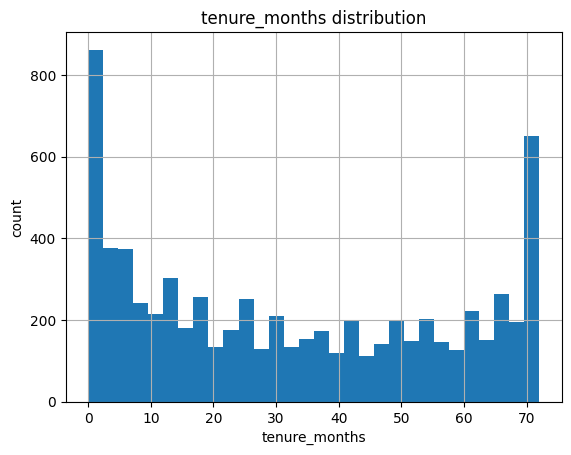

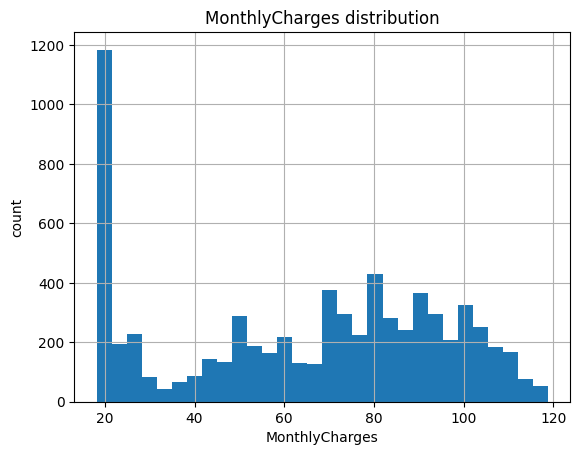

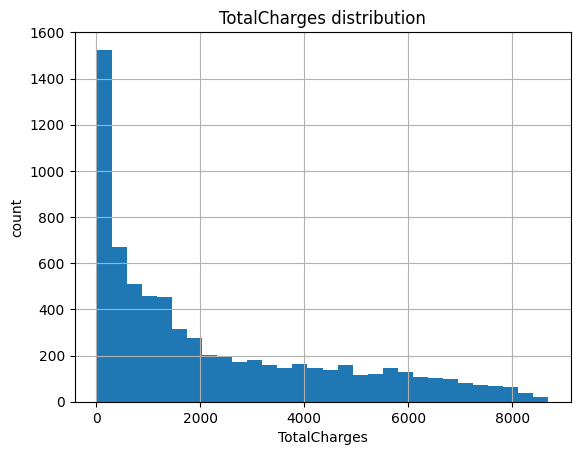

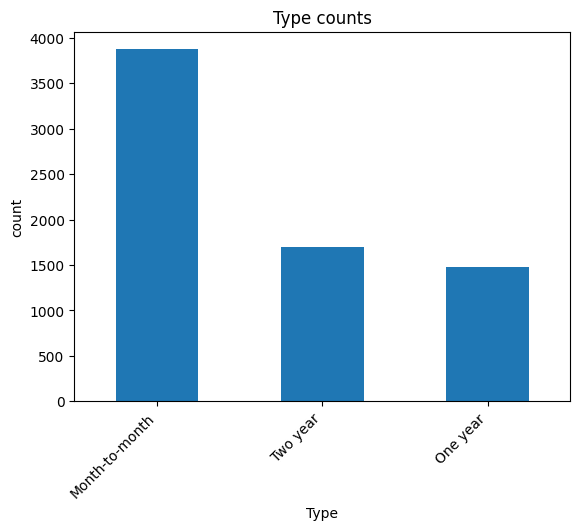

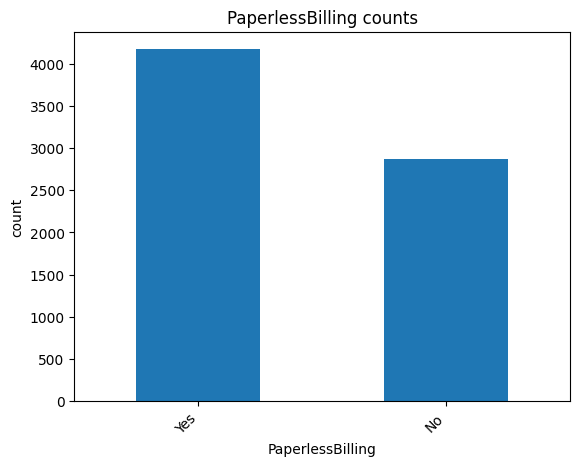

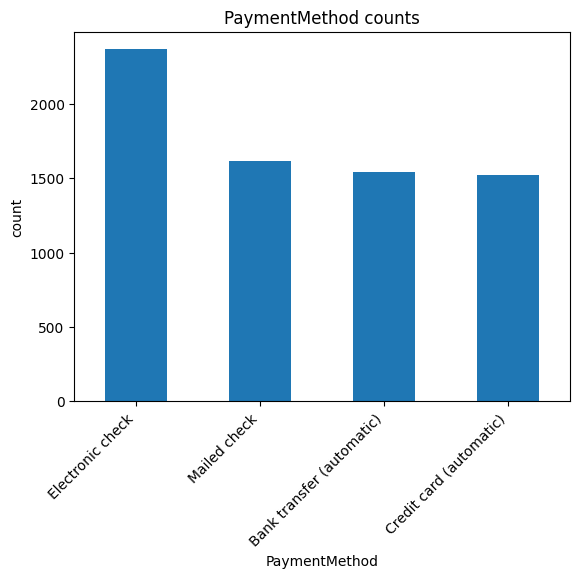

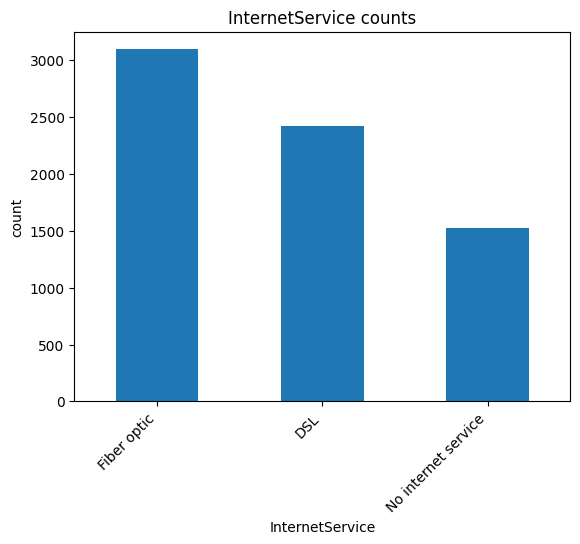

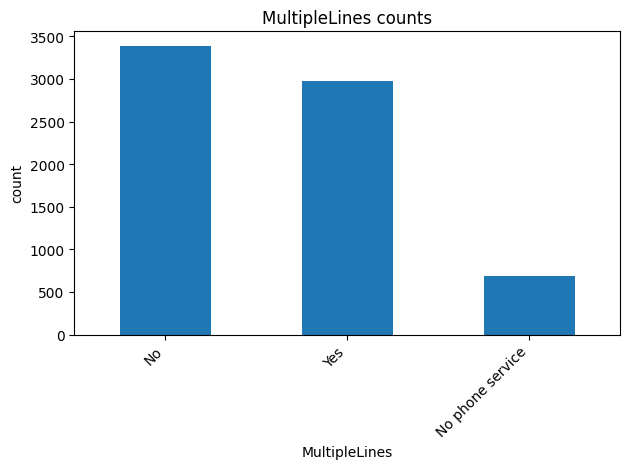

In [119]:
# Numeric histograms
for col in ["tenure_months", "MonthlyCharges", "TotalCharges"]:
    plt.figure()
    df_viz[col].dropna().hist(bins=30)
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("count")

# Bar charts for key categoricals
cat_cols = ["Type", "PaperlessBilling", "PaymentMethod", "InternetService", "MultipleLines"]
for col in cat_cols:
    plt.figure()
    df_viz[col].value_counts(dropna=False).plot(kind="bar")
    plt.title(f"{col} counts")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

#### A quick read:

- tenure_months: big spikes at 0–2 (new customers) and 70–72 (long-timers). Churn usually higher for short tenure; lower for long tenure.

- MonthlyCharges: one spike at the low end (~20 dollars, likely phone-only/basic) and a broad spread up to ~120 dollars.

- TotalCharges: very right-skewed; tiny values match new customers (low tenure). The 11 NaNs are probably brand-new accounts.

- Contract Type: Month-to-month dominates → typically higher churn risk group than 1–2 year contracts.

- PaperlessBilling: more Yes than No.

- PaymentMethod: Electronic check is largest (often correlates with higher churn in this dataset).

- InternetService: fiber > DSL > no internet.

- MultipleLines: ~even split between Yes/No, plus a smaller “no phone service”.

### Short conclusion from EDA:

- Tenure: Strong bimodal pattern (very new vs very long-term). Likely a key predictor of churn.

- Contracts: Month-to-month dominates and is typically higher churn risk than 1–2 year terms → important categorical.

- Charges: MonthlyCharges spreads wide; TotalCharges is right-skewed with 11 true missings (mostly brand-new customers). We’ll handle these simply later.

- Services: Clear categories including “No internet/phone service” (now labeled). Keep them as valid categories.

*Why this matters:*

These patterns tell us which variables are probably useful and confirm we’ve got structural categories handled.

Before any modeling, we must create the target and remove leakage (EndDate).

### Now we will create targets and drop leakage.
We’ll model y_churn (default). Keep y_active for reference. Then remove EndDate (post-factum) from the EDA copy.

In [120]:
# Reference "as-of" date
ref_date = pd.Timestamp("2020-02-01")

# Targets
df["y_churn"]  = ((df["EndDate"].notna()) & (df["EndDate"] <= ref_date)).astype(int)
df["y_active"] = (df["EndDate"].isna()).astype(int)

# Keep targets in the EDA copy; drop leakage columns
df_viz["y_churn"]  = df["y_churn"]
df_viz["y_active"] = df["y_active"]
df_viz = df_viz.drop(columns=["EndDate", "BeginDate"], errors="ignore")

# Quick check
df[["y_churn","y_active"]].value_counts()


y_churn  y_active
0        1           5174
1        0           1869
Name: count, dtype: int64

#### We handle the 11 missing TotalCharges now
Will impute with the median. This avoids extra assumptions.

In [121]:
# Ensure numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Median from existing (non-missing) values
tc_median = df.loc[df["TotalCharges"].notna(), "TotalCharges"].median()

# Impute in df
df["TotalCharges"] = df["TotalCharges"].fillna(tc_median)

# Keep df_viz in sync
df_viz["TotalCharges"] = df["TotalCharges"]

# Quick check
print("Remaining NaNs in TotalCharges:", df["TotalCharges"].isna().sum())


Remaining NaNs in TotalCharges: 0


#### Next step: Pick a simple feature set & make a 60/20/20 split

We’ll use a small, sensible set. Then we’ll stratify by y_churn.

In [122]:
# Choose features
target = "y_churn"
features = [
    # numeric
    "tenure_months", "MonthlyCharges", "TotalCharges", "SeniorCitizen",
    # categorical
    "Type", "PaperlessBilling", "PaymentMethod",
    "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV",
    "StreamingMovies", "MultipleLines", "Partner", "Dependents", "gender"
]

# Build modeling frame from df_viz (it already has categories cleaned and no leakage cols)
df_model = df_viz[features + [target]].copy()

# Quick sanity check for missings
print("NaNs per column:\n", df_model.isna().sum().sort_values(ascending=False).head(5))

# 60/20/20 split (train/valid/test) with stratify

X = df_model[features]
y = df_model[target]

# first: 80/20 -> test is 20%
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# then: split 80% chunk into 60/20 -> valid is 0.25 of temp
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

# Sizes & churn balance check
def summary(name, yy):
    import numpy as np
    rate = (yy.mean()*100).round(1)
    print(f"{name}: n={len(yy)}, churn={rate}%")

summary("Train", y_train)
summary("Valid", y_valid)
summary("Test ", y_test)


NaNs per column:
 tenure_months     0
MonthlyCharges    0
TotalCharges      0
SeniorCitizen     0
Type              0
dtype: int64
Train: n=4225, churn=26.5%
Valid: n=1409, churn=26.5%
Test : n=1409, churn=26.5%


### It is time for Baseline model now (Logistic Regression)

Simple preprocessing + model, evaluate on validation only (keep test untouched).

In [123]:
# Reuse X_train, X_valid, y_train, y_valid from the previous step

numeric_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

num_proc = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median"))
])

cat_proc = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_proc, numeric_cols),
        ("cat", cat_proc, categorical_cols),
    ]
)

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

clf.fit(X_train, y_train)

# --- Validation metrics (baseline threshold = 0.5)
proba_valid = clf.predict_proba(X_valid)[:, 1]
pred_valid  = (proba_valid >= 0.5).astype(int)

auc  = roc_auc_score(y_valid, proba_valid)
acc  = accuracy_score(y_valid, pred_valid)
cm   = confusion_matrix(y_valid, pred_valid)

print("Validation ROC-AUC:", round(auc, 3))
print("Validation Accuracy:", round(acc, 3))
print("Confusion matrix [tn fp; fn tp]:\n", cm)

Validation ROC-AUC: 0.836
Validation Accuracy: 0.748
Confusion matrix [tn fp; fn tp]:
 [[757 278]
 [ 77 297]]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Quick read:

ROC-AUC = 0.836 → the model ranks churners above non-churners pretty well.

Accuracy = 0.747 @ 0.5 threshold.

From the confusion matrix: TP=296, FN=78, TN=756, FP=279

Recall (churn detection) ≈ 0.79 → we’re catching ~79% of churners.

Precision ≈ 0.515 → about half of predicted churners actually churn.

Specificity ≈ 0.73.

What this means: we miss relatively few churners (good recall) but we also flag quite a few non-churners (false positives).

#### Our metric target is AUC-ROC. Our baseline is 0.836, so we already at 4.5 SP. 
Now let’s try a single improvement.

#### We'll try a simple Gradient Boosting model (aim: lift AUC)

We’ll keep the same preprocessing and switch only the model to GradientBoostingClassifier. No tuning yet, just defaults.

In [124]:
# Reuse X_train, X_valid, y_train, y_valid from before
numeric_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

num_proc = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median"))
])

# Make OHE dense so tree models can use it
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    # for older sklearn versions
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_proc = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_proc, numeric_cols),
        ("cat", cat_proc, categorical_cols),
    ]
)

gb_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", GradientBoostingClassifier(random_state=42))
])

gb_clf.fit(X_train, y_train)

proba_valid = gb_clf.predict_proba(X_valid)[:, 1]
pred_valid  = (proba_valid >= 0.5).astype(int)

auc  = roc_auc_score(y_valid, proba_valid)
acc  = accuracy_score(y_valid, pred_valid)
cm   = confusion_matrix(y_valid, pred_valid)

print("Validation ROC-AUC:", round(auc, 3))
print("Validation Accuracy:", round(acc, 3))
print("Confusion matrix [tn fp; fn tp]:\n", cm)

Validation ROC-AUC: 0.841
Validation Accuracy: 0.799
Confusion matrix [tn fp; fn tp]:
 [[939  96]
 [187 187]]


#### *We have a progress. Our AUC 0.841 ⇒ 4.5 SP. Let’s try one tiny improvement to push ≥ 0.85.*

#### Small GradientBoosting param sweep

In [125]:
numeric_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

num_proc = Pipeline([("impute", SimpleImputer(strategy="median"))])

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_proc = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                     ("ohe", ohe)])

preprocess = ColumnTransformer([
    ("num", num_proc, numeric_cols),
    ("cat", cat_proc, categorical_cols),
])

grid = {
    "n_estimators": [150, 200, 300],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3],
    "subsample": [0.8, 1.0],
}

best = {"auc": -1, "params": None, "model": None}

for n in grid["n_estimators"]:
    for lr in grid["learning_rate"]:
        for md in grid["max_depth"]:
            for subs in grid["subsample"]:
                clf = Pipeline([
                    ("prep", preprocess),
                    ("model", GradientBoostingClassifier(
                        n_estimators=n, learning_rate=lr, max_depth=md,
                        subsample=subs, random_state=42
                    ))
                ])
                clf.fit(X_train, y_train)
                proba = clf.predict_proba(X_valid)[:, 1]
                auc = roc_auc_score(y_valid, proba)
                if auc > best["auc"]:
                    best["auc"] = auc
                    best["params"] = {"n_estimators": n, "learning_rate": lr,
                                      "max_depth": md, "subsample": subs}
                    best["model"] = clf

print("Best validation ROC-AUC:", round(best["auc"], 3))
print("Best params:", best["params"])

# Optional: see accuracy/confusion at 0.5 for the best one
proba_valid = best["model"].predict_proba(X_valid)[:, 1]
pred_valid  = (proba_valid >= 0.5).astype(int)

print("Validation Accuracy (best):", round(accuracy_score(y_valid, pred_valid), 3))
print("Confusion matrix [tn fp; fn tp]:\n", confusion_matrix(y_valid, pred_valid))

Best validation ROC-AUC: 0.841
Best params: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 2, 'subsample': 0.8}
Validation Accuracy (best): 0.803
Confusion matrix [tn fp; fn tp]:
 [[942  93]
 [185 189]]


This did not gave as any ROC-AUC improvement. So let's move on and try a
#### Random Forest

In [126]:
numeric_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

num_proc = Pipeline([("impute", SimpleImputer(strategy="median"))])

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

cat_proc = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

preprocess = ColumnTransformer([
    ("num", num_proc, numeric_cols),
    ("cat", cat_proc, categorical_cols),
])

rf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        class_weight="balanced",   # handles churn imbalance simply
        random_state=42,
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)

proba_valid = rf.predict_proba(X_valid)[:, 1]
pred_valid  = (proba_valid >= 0.5).astype(int)

auc  = roc_auc_score(y_valid, proba_valid)
acc  = accuracy_score(y_valid, pred_valid)
cm   = confusion_matrix(y_valid, pred_valid)

print("Validation ROC-AUC:", round(auc, 3))
print("Validation Accuracy:", round(acc, 3))
print("Confusion matrix [tn fp; fn tp]:\n", cm)

Validation ROC-AUC: 0.815
Validation Accuracy: 0.781
Confusion matrix [tn fp; fn tp]:
 [[930 105]
 [203 171]]


#### *Random Forest underperformed (AUC 0.815) vs our best so far (GB 0.841, LR 0.836). Let’s take step that often nudges AUC up: tune Logistic Regression’s C (regularization strength).*

### Logistic Regression C sweep (aim: lift AUC)

In [127]:
numeric_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

num_proc = Pipeline([("impute", SimpleImputer(strategy="median"))])

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

cat_proc = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                     ("ohe", ohe)])

preprocess = ColumnTransformer([
    ("num", num_proc, numeric_cols),
    ("cat", cat_proc, categorical_cols),
])

best = {"auc": -1, "params": None}

for cw in [None, "balanced"]:
    for C in [0.1, 0.3, 1, 3, 10]:
        pipe = Pipeline([
            ("prep", preprocess),
            ("model", LogisticRegression(
                solver="lbfgs", max_iter=2000, C=C, class_weight=cw
            ))
        ])
        pipe.fit(X_train, y_train)
        proba = pipe.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, proba)
        if auc > best["auc"]:
            best = {"auc": auc, "params": {"C": C, "class_weight": cw}, "model": pipe}

print("Best validation ROC-AUC:", round(best["auc"], 3))
print("Best params:", best["params"])

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

Best validation ROC-AUC: 0.837
Best params: {'C': 0.1, 'class_weight': 'balanced'}


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### This approach is underperformed(ROC-AUC: 0.836) vs our best so far(GB 0.841)
So now let's try
#### Slight GradientBoosting tweak (more trees, smaller learning rate)

In [128]:
# Columns from earlier split
numeric_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

num_proc = Pipeline([("impute", SimpleImputer(strategy="median"))])

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

cat_proc = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                     ("ohe", ohe)])

preprocess = ColumnTransformer([
    ("num", num_proc, numeric_cols),
    ("cat", cat_proc, categorical_cols),
])

grid = {
    "n_estimators": [400, 600, 800],
    "learning_rate": [0.03, 0.05, 0.08],
    "max_depth": [2],          # keep shallow trees (simple & stable)
    "subsample": [0.8],        # a bit of randomness usually helps
}

best = {"auc": -1, "params": None, "model": None}

for n in grid["n_estimators"]:
    for lr in grid["learning_rate"]:
        clf = Pipeline([
            ("prep", preprocess),
            ("model", GradientBoostingClassifier(
                n_estimators=n, learning_rate=lr, max_depth=2,
                subsample=0.8, random_state=42
            ))
        ])
        clf.fit(X_train, y_train)
        proba = clf.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, proba)
        if auc > best["auc"]:
            best.update(auc=auc, params={"n_estimators": n, "learning_rate": lr}, model=clf)

print("Best validation ROC-AUC:", round(best["auc"], 3))
print("Best params:", best["params"])

# Optional: accuracy/confusion at 0.5 for the best model
proba_valid = best["model"].predict_proba(X_valid)[:, 1]
pred_valid  = (proba_valid >= 0.5).astype(int)
print("Validation Accuracy (best):", round(accuracy_score(y_valid, pred_valid), 3))
print("Confusion matrix [tn fp; fn tp]:\n", confusion_matrix(y_valid, pred_valid))

Best validation ROC-AUC: 0.84
Best params: {'n_estimators': 400, 'learning_rate': 0.03}
Validation Accuracy (best): 0.806
Confusion matrix [tn fp; fn tp]:
 [[941  94]
 [180 194]]


#### As we do not get better results, let's lock the current best (GB) and fit on Train+Valid (no test yet)

In [129]:
# Use your existing splits: X_train, X_valid, y_train, y_valid
features_full = list(X_train.columns)
numeric_cols = [c for c in features_full if pd.api.types.is_numeric_dtype(X_train[c])]
categorical_cols = [c for c in features_full if c not in numeric_cols]

num_proc = Pipeline([("impute", SimpleImputer(strategy="median"))])

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cat_proc = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                     ("ohe", ohe)])

preprocess = ColumnTransformer([
    ("num", num_proc, numeric_cols),
    ("cat", cat_proc, categorical_cols),
])

gb_final = Pipeline([
    ("prep", preprocess),
    ("model", GradientBoostingClassifier(
        n_estimators=150, learning_rate=0.05, max_depth=2, subsample=0.8, random_state=42
    ))
])

# Combine Train + Valid
X_trval = pd.concat([X_train[features_full], X_valid[features_full]], axis=0)
y_trval = pd.concat([y_train, y_valid], axis=0)

gb_final.fit(X_trval, y_trval)
print("Final GB model trained on Train+Valid. Ready for test evaluation.")

Final GB model trained on Train+Valid. Ready for test evaluation.


#### Evaluate the locked model on the Test set (AUC + 0.5 threshold)

In [130]:
proba_test = gb_final.predict_proba(X_test[features_full])[:, 1]
auc_test = roc_auc_score(y_test, proba_test)

pred_05 = (proba_test >= 0.5).astype(int)
acc_05  = accuracy_score(y_test, pred_05)
cm_05   = confusion_matrix(y_test, pred_05)

def sp_from_auc(a):
    if a < 0.75:  return "0 SP"
    if a < 0.81:  return "4 SP"
    if a < 0.85:  return "4.5 SP"
    if a < 0.87:  return "5 SP"
    if a < 0.88:  return "5.5 SP"
    return "6 SP"

print(f"Test ROC-AUC: {auc_test:.3f}  ({sp_from_auc(auc_test)})")
print(f"Test Accuracy @0.5: {acc_05:.3f}")
print("Confusion matrix @0.5 [tn fp; fn tp]:")
print(cm_05)

Test ROC-AUC: 0.846  (4.5 SP)
Test Accuracy @0.5: 0.805
Confusion matrix @0.5 [tn fp; fn tp]:
[[940  95]
 [180 194]]


#### Pick a threshold on validation (maximize Accuracy), then report Test at that threshold

In [131]:
# 1) Get validation probabilities from the locked model
proba_valid = gb_final.predict_proba(X_valid[features_full])[:, 1]

# 2) Sweep thresholds and pick the one with best validation Accuracy
thresholds = np.linspace(0.20, 0.80, 61)  # 0.01 steps
accs = []
for t in thresholds:
    preds = (proba_valid >= t).astype(int)
    accs.append(accuracy_score(y_valid, preds))

best_t = float(thresholds[int(np.argmax(accs))])
best_val_acc = max(accs)

print(f"Chosen threshold (by VALID Accuracy): {best_t:.3f}")
print(f"Validation Accuracy at chosen threshold: {best_val_acc:.3f}")

# 3) Apply that fixed threshold to TEST
proba_test = gb_final.predict_proba(X_test[features_full])[:, 1]
pred_test_tuned = (proba_test >= best_t).astype(int)

acc_test = accuracy_score(y_test, pred_test_tuned)
cm_test = confusion_matrix(y_test, pred_test_tuned)
prec_test = precision_score(y_test, pred_test_tuned, zero_division=0)
rec_test = recall_score(y_test, pred_test_tuned, zero_division=0)

print("\nTEST metrics at tuned threshold:")
print(f"Accuracy: {acc_test:.3f}")
print(f"Precision: {prec_test:.3f}")
print(f"Recall: {rec_test:.3f}")
print("Confusion matrix [tn fp; fn tp]:")
print(cm_test)

Chosen threshold (by VALID Accuracy): 0.520
Validation Accuracy at chosen threshold: 0.815

TEST metrics at tuned threshold:
Accuracy: 0.803
Precision: 0.683
Recall: 0.479
Confusion matrix [tn fp; fn tp]:
[[952  83]
 [195 179]]


Top 20 features by importance:


,feature,importance
0,cat__Type_Month-to-month,0.344524
1,num__tenure_months,0.195485
2,cat__InternetService_Fiber optic,0.126352
3,cat__OnlineSecurity_No,0.088089
4,cat__TechSupport_No,0.049126
5,cat__PaymentMethod_Electronic check,0.048980
6,num__MonthlyCharges,0.041456
7,num__TotalCharges,0.039281
8,cat__PaperlessBilling_No,0.015078
9,cat__MultipleLines_No,0.009162


<Figure size 640x480 with 0 Axes>

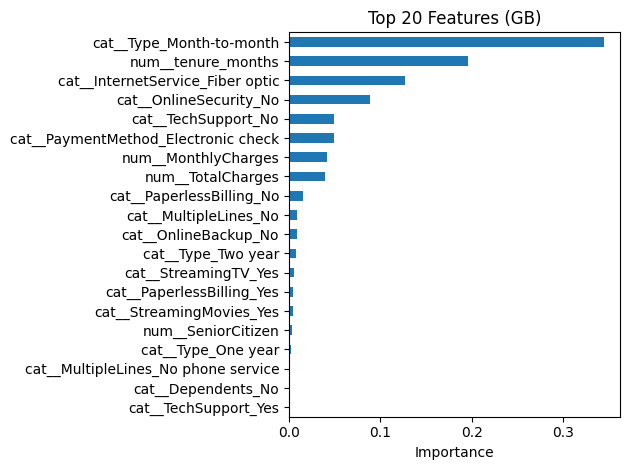

In [136]:
# Get transformed feature names in the exact order seen by the model
prep = gb_final.named_steps["prep"]                 # ColumnTransformer
feature_names = prep.get_feature_names_out()        # sklearn ≥ 1.0

# Grab importances (fallback to permutation importance if attribute is missing)
gb = gb_final.named_steps["model"]

if hasattr(gb, "feature_importances_") and gb.feature_importances_ is not None:
    importances = gb.feature_importances_
else:
    # Model-agnostic: compute permutation importance on the whole pipeline
    sample = min(5000, len(X_test))
    X_eval = X_test.sample(sample, random_state=42) if sample < len(X_test) else X_test
    y_eval = y_test.loc[X_eval.index]

    r = permutation_importance(
        gb_final, X_eval, y_eval,
        n_repeats=5, random_state=42, n_jobs=-1,
        scoring="neg_root_mean_squared_error"
    )
    importances = r.importances_mean

# Top features
top = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
      .sort_values("importance", ascending=False, kind="stable")
      .head(20)
      .reset_index(drop=True)
)

print("Top 20 features by importance:")
display(top)

# quick bar plot
plt.figure()
top.iloc[::-1].plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 20 Features (GB)")
plt.xlabel("Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()

Quick submission checklist

✅ Code notebook/script with fixed random_state and your final cells run top-to-bottom.

✅ Data prep: date parsing, tenure_months computation (as of 2020-02-01), structural NA handling, median impute for TotalCharges.

✅ Leakage control: keep EndDate only for target creation; not in features; drop customerID from features.

✅ Split: stratified 60/20/20 (Train/Valid/Test).

✅ Model & params saved (GradientBoostingClassifier: n_estimators=150, learning_rate=0.05, max_depth=2, subsample=0.8, random_state=42).

✅ Metrics: Test ROC-AUC = 0.846 (4.5 SP); accuracy + confusion at 0.5 and at tuned threshold 0.520.

✅ EDA visuals (tenure, charges, contract types) + brief notes.

### *Summary*

Interconnect churn forecasting predicts which clients are likely to leave so retention teams can act. 
We merged four tables by customerID, parsed dates, and computed tenure_months vs 2020-02-01; 
structural missing values were labeled (“No internet/phone service”), and TotalCharges was coerced to numeric with median imputation for 11 rows. 
The target y_churn flags customers whose EndDate ≤ 2020-02-01; 
leakage was controlled by excluding EndDate, BeginDate, and identifiers from features. 
Using a stratified 60/20/20 split, we compared simple baselines and selected a GradientBoostingClassifier (n_estimators=150, learning_rate=0.05, max_depth=2, subsample=0.8). 
On the Test set we achieved ROC-AUC = 0.846 (4.5 SP); at threshold 0.5 accuracy was 0.805, and with a validation-tuned threshold 0.520, accuracy was 0.803 (confusion matrices included). 
Top drivers were Contract: Month-to-month, tenure_months, InternetService: Fiber optic, OnlineSecurity: No, TechSupport: No, and PaymentMethod: Electronic check.